### This  note book tests the iran

In [1]:
import pandas as pd
import numpy as np
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os
import networkx as nx

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as vz
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config

In [2]:
config = config.config()
path = config['PATHS']

derived_path = path['derived_path']
all_tweet_data = path['all_tweet_data']
plot_path = path['plot_path']

In [3]:
reply_path = os.path.join(derived_path, 
                          'user_coordination_graph')

In [4]:
all_campaigns, names = st.bundle_campaign()

In [5]:
year = '2020_12'
campaign = 'iran_202012'
type_of = 'ops'

file_hp.create_folder(reply_path, campaign)
coord_path = os.path.join(reply_path, campaign)

In [6]:
data_path = st.get_data_path(all_tweet_data, 
                                 year, 
                                 campaign)

df = st.read_ops_control_data(data_path['ops'],
                                data_path['control'], 
                             [type_of])['ops']

df_iran = st.reply_to_external_users(df)

In [7]:
info = {}

In [8]:
#### basic statistics

io_accounts = df_iran['userid'].nunique()
print('Number of IO accounts involved in replying ', 
      io_accounts)
posters = df_iran['in_reply_to_userid'].nunique()
print('Number of Posters ', 
      posters)


info['io_accounts'] = io_accounts
info['posters'] = posters

Number of IO accounts involved in replying  180
Number of Posters  27445


In [25]:
def plot_histogram(df, column, 
                   xlabel, ylabel,
                   plot_path, title,
                   filename,
                   num = 60,
                   xscale=False,
                   yscale=False,
                  ):
    
    # df[column] = df[column].apply(
    #     lambda x: np.log10(x))
    fig, ax = plt.subplots()
    if num == None:
        num = df[column].nunique()
        num_bins = num
#     if xscale == True and num == None:
#         num = df[column].nunique()
        
        
    # if xscale == True and num is not None:
    #     num = num
        
    if xscale == True:
        num_bins=np.logspace(start=np.log10(min(df[column])), 
                             stop=np.log10(max(df[column])),
                             num=num
                            )
        
    n = ax.hist(df[column],
                bins=num_bins, 
                # log=True
               )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if yscale == True:
        plt.yscale('log')
    if xscale == True:
        plt.xscale('log')
        
    plt.title(title)
    fig.savefig(f'{plot_path}/{title}', 
              facecolor='white', 
              transparent=False)
    plt.show()

##### **How many tweets each Poster have**
How many replies each poster got?

Posters having tweets greater than equal 5: 2153
Posters having tweets greater than equal 10: 1010


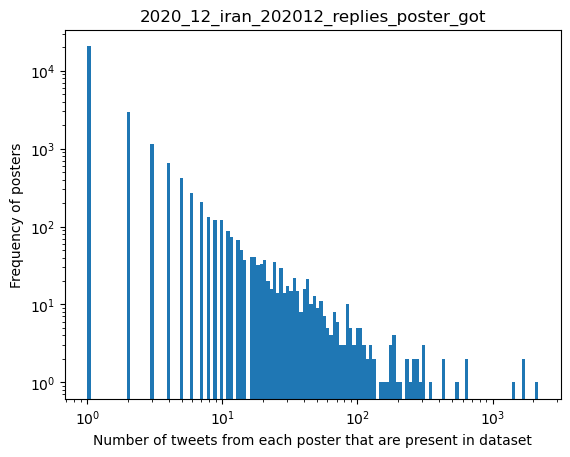

In [43]:
df_grp_tweets = (df_iran.groupby(['in_reply_to_userid'])['in_reply_to_tweetid']
                 .nunique()
                 .to_frame('count_tweets')
                 .reset_index()
                )

total_poster_gt_5 = len(df_grp_tweets.loc[df_grp_tweets['count_tweets'] >= 5])
print('Posters having tweets greater than equal 5:', 
      total_poster_gt_5)

total_poster_gt_10 = len(df_grp_tweets.loc[df_grp_tweets['count_tweets'] >= 10])
print('Posters having tweets greater than equal 10:', 
      total_poster_gt_10)

info['total_poster_gt_5'] = total_poster_gt_5
info['total_poster_gt_10'] = total_poster_gt_10

plot_histogram(df_grp_tweets, 
               'count_tweets',
               'Number of tweets from each poster that are present in dataset', 
               'Frequency of posters',
               plot_path, 
               f'{year}_{campaign}_replies_poster_got',
               f'{year}_{campaign}_poster_tweets.png',
               None,
               True,
               True
              )

In [49]:
user_5 = df_grp_tweets.loc[df_grp_tweets['count_tweets'] >= 5]['in_reply_to_userid'].unique()

df_conversation_id = df_iran.loc[
    df_iran['in_reply_to_userid'].isin(user_5)]['in_reply_to_tweetid'].unique()

In [53]:
len(df_conversation_id)
# file_hp.write_to_file_row_each_line('./',
#                                     'iran_202012_conv.txt',
#                                     df_conversation_id
#                                    )

46610

##### **Testing if iran dataset can be used for tweet level reply coordination**
How many replies each tweet got?

In [22]:
df_grps = (df_iran.groupby(['in_reply_to_userid',
                                       'in_reply_to_tweetid'
                                      ])['userid'].nunique()
                              .to_frame('count_replies')
                              .reset_index())

In [23]:
total_io_account_5 = len(df_grps.loc[df_grps['count_replies'] >= 5])

info['io_account_reply_each_tweet_5'] = total_io_account_5
print(total_io_account_5)

23


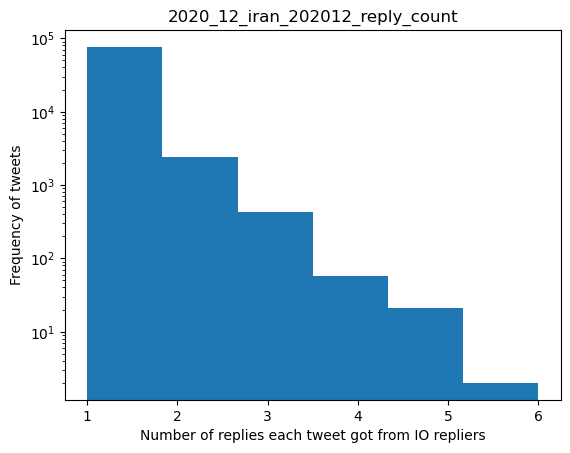

In [26]:
plot_histogram(df_grps, 'count_replies',
               'Number of replies each tweet got from IO repliers', 
               'Frequency of tweets',
               plot_path, f'{year}_{campaign}_reply_count',
               f'{year}_{campaign}_users_replying.png',
               None,
               False,
               True
              )

##### **Conclusion : Most of the tweets got less than 2 replies. Not suitable**

##### **How many posters did each IO account engaged with?**

Number of io accounts replying to 5 or more posters  139


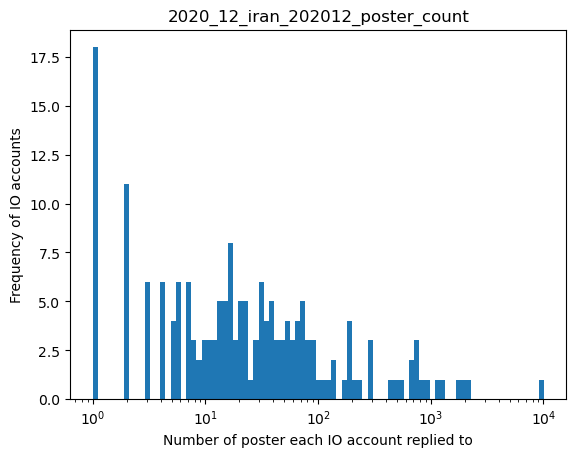

In [31]:
df_poster = (df_iran.groupby(['userid'])['in_reply_to_userid'].nunique()
                              .to_frame('count_poster')
                              .reset_index())

info['poster_count_per_io_account'] = len(df_poster.loc[df_poster['count_poster'] >=5])

print('Number of io accounts replying to 5 or more posters ',
      info['poster_count_per_io_account'])
plot_histogram(df_poster, 'count_poster',
               'Number of poster each IO account replied to', 
               'Frequency of IO accounts',
               plot_path, f'{year}_{campaign}_poster_count',
               f'{year}_{campaign}_poster_count.png',
               None,
               True,
               False
              )

##### ***How many times each IO account replied poster***

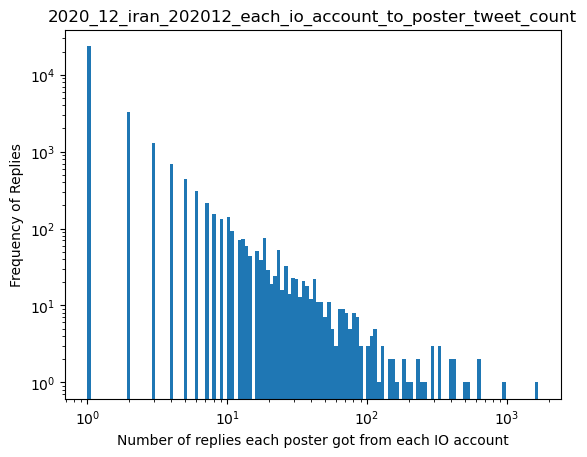

In [41]:
df_prop_each = (df_iran.groupby(['in_reply_to_userid',
                                       'userid'
                                      ])['in_reply_to_tweetid'].nunique()
                              .to_frame('count_replies')
                              .reset_index())

plot_histogram(df_prop_each, 'count_replies',
               'Number of replies each poster got from each IO account', 
               'Frequency of Replies',
               plot_path, f'{year}_{campaign}_each_io_account_to_poster_tweet_count',
               f'{year}_{campaign}_each_to_each_count.png',
               None,
               True,
               True
              )

##### **Out of all the tweets from poster, how many tweets an IO account replies to (that is proportion of tweets that each IO account replied to compared to total tweets present for each poster in dataset)?**

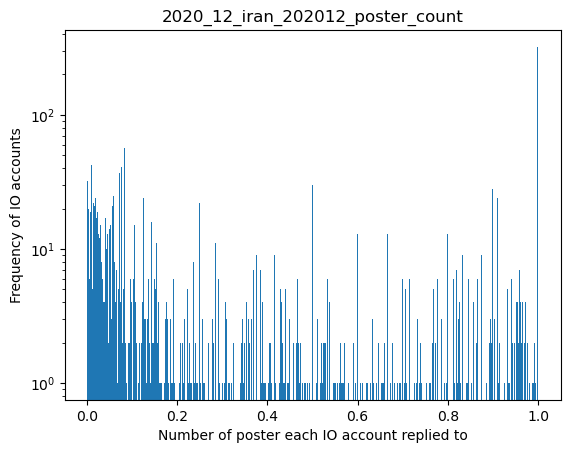

In [63]:
df_total_each = (df_iran.groupby(['in_reply_to_userid'])
                 .size()
                 .to_frame('count')
                 .reset_index())

df_total_each = df_total_each.loc[
    df_total_each['count'] >=10]

df_prop = df_total_each.merge(df_prop_each, on=['in_reply_to_userid'])

df_prop['proportion'] = df_prop['count_replies'] / df_prop['count']
df_prop = df_prop.loc[df_prop['proportion'] > 0]

plot_histogram(df_prop, 'proportion',
               'Number of poster each IO account replied to', 
               'Frequency of IO accounts',
               plot_path, f'{year}_{campaign}_poster_count',
               f'{year}_{campaign}_proportion.png',
               None,
               False,
               True
              )

##### **Testing if coordination can be studied**
What is the level of coordination in the data in replying to posters?

In [ ]:
df_grps_userid = (df_iran.groupby(['in_reply_to_userid',
                                       'userid'
                                      ])['in_reply_to_tweetid'].nunique()
                              .to_frame('count_replies')
                              .reset_index())

In [ ]:
plot_histogram(df_grps_userid, 'count_replies',
               'Number of tweets io account are replying to each poster', 
               'Frequency of io accounts',
               plot_path, f'{year}_{campaign}_users_replying',
               f'{year}_{campaign}_users_replying.png',
               None,
               True,
               False
              )

In [14]:
total_coord_reply_5 = len((df_grps_userid.loc[df_grps_userid['count_replies'] >= 5]
 .sort_values(by=['count_replies'],
              ascending=False)
))

print('Number of io account that are replying to more than 5 tweets from poster \n',
     total_coord_reply_5)

Number of io account that are replying to more than 5 tweets from poster 
 2364


##### **It has sufficient users**

### **Testing if it is suitable for coordination study**

In [15]:
def filter_poster(df, filter_tweet = 10):
    '''
    Filter out posters with less than 10 tweets
    
    :param df: dataframe
    :param filter_tweet: filter threshold
    '''
    df = df.loc[~df['in_reply_to_userid'].isnull()]
    
    userids = (df
        .groupby(['in_reply_to_userid'])['in_reply_to_tweetid']
        .size()
        .to_frame('tweet_count')
        .reset_index()
        .query('tweet_count >= {}'.format(filter_tweet))
        )['in_reply_to_userid'].tolist()
    
    df = df.loc[df['in_reply_to_userid'].isin(userids)]
    
    return df

In [51]:
def coordination_reply(df, 
                       output_path,
                       graph_info=True,
                       name=None
                      ):
    # print('\n----- Start: Filtering tweets ---------')
    # df = st.filter_reply_count(df, 5)
    # print('----- End: Filtering tweets ---------\n')
    # print(df['in_reply_to_tweetid']
    # print('\n----- Start: Create bi-partite network -----')
    df_network = hp.create_user_projection(df, 
                                        'in_reply_to_tweetid')
    
    if len(df_network) == 0:
        return None
    # print('\n----- End: Create bi-partite network -----')
    
    # print('\n----- Start: Create co-reply strings  -----')
    df_string = hp.convert_tweetids_to_string(df, 
                                           field='in_reply_to_tweetid')
    # print('\n----- End: Create co-reply strings -----')
    
    # print('\n----- Start: Calculate tfidf vector -----')
    df_string = hp.calculate_tf_idf_vector(df_string)
    # print('\n------ End: Calculate tfidf vector -----')
    
    # print('\n----- Start: Retweet user projection network ------')
    df_new = hp.calculate_cosine_similarity(df_network, 
                                            df_string)
    
    if len(df_new) == 0:
        return None
    # print('\n----- End: Retweet user projection network -----')
       
    if name == None:
        pkl_path = os.path.join(output_path, 
                                f'all_user_network.pkl.gz')
    else:
        pkl_path = os.path.join(output_path, 
                                f'{name}_user_network.pkl.gz')
    
    df_new.to_pickle(f'{pkl_path}')
    
    # print('\n ----- Start: Create co-retweet graph -----')
    # create_graph(df_new, 
    #              output_path,
    #              campaign_name=campaign_name,
    #              source_column='source',
    #              target_column='target',
    #              weight_column='cosine',
    #              type_text='co-reply')
    # print(f'----- End: Creating user projection network ---------\n')
        
    if graph_info == True:
        G = get_graph_info(df_new)
        
        return df_new, G
    
    return df_new

In [17]:
def get_graph_info(df,
                   source_column = 'source',
                   target_column = 'target',
                   weight_column = 'cosine'
                  ):
    G = nx.from_pandas_edgelist(df, 
                                source_column, 
                                target_column, 
                                [weight_column])
    
    Gcc = sorted(nx.connected_components(G), 
                 key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    
    print('Number of graph component info \n ')
    print(len(Gcc))
    print('\n Number of node info ', G.number_of_nodes())
    print('\n Number of edges info ', G.number_of_edges())
    print('\n Giant component info :', nx.info(G0))
    
    return Gcc

In [18]:
df_new, G = coordination_reply(df_iran, reply_path)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 34 to 90811
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  534 non-null    int64
 1   userid_y  534 non-null    int64
dtypes: int64(2)
memory usage: 12.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     180 non-null    int64 
 1   tweet_ids  180 non-null    object
 2   vector     180 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 0 to 533
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  534 non-null    int64 
 1   userid_y  534 non-null    int64 
 2   userid    534 non-null    int64 
 3   vector    534 non-null    object
dtypes: int64(3

100%|██████████| 534/534 [00:00<00:00, 923611.68it/s]

[0.1  0.23 0.03 0.   0.02 0.09 0.01 0.04 0.63 0.47 0.39 0.26 0.06 0.45
 0.37 0.28 0.41 0.07 0.05 0.25 0.14 0.08 0.15 0.12 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 0 to 533
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  314 non-null    int64  
 1   userid_y  314 non-null    int64  
 2   cosine    314 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 9.8 KB
None
Number of graph component info 
 
10

 Number of node info  99

 Number of edges info  157

 Giant component info : Graph with 50 nodes and 82 edges



/tmp/ipykernel_50565/4040382118.py:19: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print('\n Giant component info :', nx.info(G0))


In [19]:
# plot_histogram(df_grps_userid, 'count_replies',
#                'Number of tweets io account are replying to each poster', 
#                'Frequency of io accounts',
#                plot_path, f'{year}_{campaign}_users_replying',
#                f'{year}_{campaign}_users_replying.png',
#                True
#               )

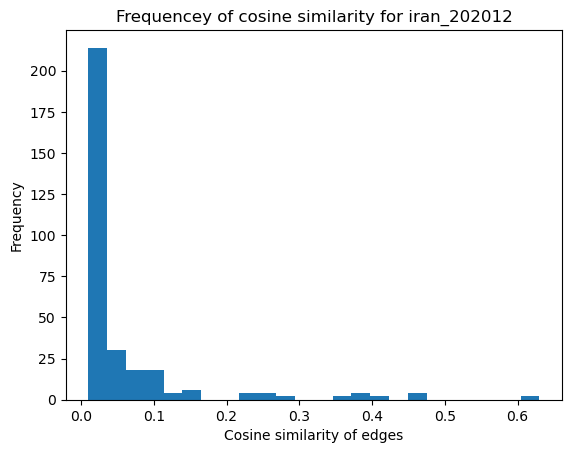

In [20]:
plot_histogram(df_new, 'cosine', 'Cosine similarity of edges', 
               'Frequency', plot_path,
               f'Frequencey of cosine similarity for {campaign}',
               f'{year}_{campaign}_cosine.png'
              )

##### **Cosine similiary for whole graph is very less**

### **Testing user level coordination study**

In [52]:
def user_level_coordination(df):
    ### only posters with greater than equal to 10 tweets
    df_grp_tweets = (df.groupby(['in_reply_to_userid'])['in_reply_to_tweetid']
                 .nunique()
                 .to_frame('count_tweets')
                 .reset_index())
    poster_10 = df_grp_tweets.loc[
        df_grp_tweets['count_tweets'] >= 10]['in_reply_to_userid']
    
    df_10 = df.loc[df['in_reply_to_userid'].isin(poster_10)]
    
    ##Filter if they reply two or more tweets
    
    # df_10_grp = df_10.groupby(['in_reply_to_userid'])[['userid',
    #                              'in_reply_to_tweetid']]
    #           .nunique()
    #           .to_frame('count')
    #           .reset_index()
    
    ### only users which 
    
    #Filter users that replied to only one tweet
#     df_users_grp = (df_10.groupby(['in_reply_to_userid', 'userid'])[
#                                  'in_reply_to_tweetid']
#               .nunique()
#               .to_frame('count')
#               .reset_index())
    
#     print('Before :', df_users_grp.info())
#     df_users_grp = df_users_grp.loc[df_users_grp['count'] >= 1]
#     print('After :', df_users_grp.info())
    
    # coord_path
    print(f'{campaign} : Number of poster with greater than 10 tweets :', 
          df_10['in_reply_to_userid'].nunique())
    
    groups = df_10.groupby(['in_reply_to_userid'])[['userid',
                                 'in_reply_to_tweetid']]
    
    for grp in groups:
        df_user = grp[1].reset_index(drop=True)
        
        name = str(int(grp[0]))
        
        print(f'*** user alert: {name} ******** \n')
        
        df_coord = coordination_reply(df_user, 
                                      coord_path,
                                      graph_info=False,
                                      name=name, 
                        )
        if df_coord is None:
            continue
        print(df_coord.info())

In [53]:
user_level_coordination(df_iran, )

iran_202012 : Number of poster with greater than 10 tweets : 1010
*** user alert: 246103 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 759251 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 1 to 2518
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  60 non-null     int64
 1   userid_y  60 non-null     int64
dtypes: int64(2)
memory usage: 1.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     18 non-null     int64 
 1   tweet_ids  18 non-null     object
 2   vector     18 non-null

100%|██████████| 60/60 [00:00<00:00, 185178.98it/s]


[0.11 0.02 0.   0.06 0.05 0.03 0.01 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 58
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  40 non-null     int64  
 1   userid_y  40 non-null     int64  
 2   cosine    40 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 58
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  40 non-null     int64  
 1   target  40 non-null     int64  
 2   cosine  40 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
*** user alert: 790728 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   us

100%|██████████| 4/4 [00:00<00:00, 23933.26it/s]

[0.04 0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 813286 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 939091 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 16 to 75
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  8 non-null      int64
 1   userid_y  8 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes
None
<cl

100%|██████████| 8/8 [00:00<00:00, 67108.86it/s]


[0.16 0.19 0.03 0.44]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1367531 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non

100%|██████████| 14/14 [00:00<00:00, 61166.93it/s]

[0.04 0.01 0.07 0.02]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  14 non-null     int64  
 1   userid_y  14 non-null     int64  
 2   cosine    14 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 448.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  14 non-null     int64  
 1   target  14 non-null     int64  
 2   cosine  14 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 448.0 bytes
None
*** user alert: 2836421 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 5 to 188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  18 non-null     int64
 1   userid_y  18 non-null     int64
dtypes: int64(2)
memory usage: 432.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     15 non-null     int64 
 1   tweet_ids  15 non-null     object
 2   vector     15 non-null     object
dtypes: int64(1), object(2)
memory usage: 488.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  18 non-null     int64 
 1   userid_y  18 non-null     int64 
 2   userid    18 non-null     int64 
 3   vector    18 non-null     object
dtypes: int64(

100%|██████████| 18/18 [00:00<00:00, 164124.94it/s]

[0.05 0.02 0.08 0.04 0.   0.01]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  16 non-null     int64  
 1   userid_y  16 non-null     int64  
 2   cosine    16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  16 non-null     int64  
 1   target  16 non-null     int64  
 2   cosine  16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes
None
*** user alert: 3108351 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   u

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     8 non-null      int64 
 1   tweet_ids  8 non-null      object
 2   vector     8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  8 non-null      int64 
 1   userid_y  8 non-null      int64 
 2   userid    8 non-null      int64 
 3   vector    8 non-null      object
dtypes: int64(3), object(1)
memory usage: 320.0+ bytes
None


100%|██████████| 8/8 [00:00<00:00, 39290.90it/s]


[0.08 0.03 0.02]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 11134252 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-nul

100%|██████████| 2/2 [00:00<00:00, 9576.04it/s]


[0.39]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 13850422 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64

100%|██████████| 4/4 [00:00<00:00, 12264.05it/s]

[0.03 0.01]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 14247236 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 97
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  10 non-null     int64
 1   userid_y  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     16 non-null     int64 
 1   tweet_ids  16 non-null     object
 2   vector     16 non-null     object
dtypes: int64(1), object

100%|██████████| 10/10 [00:00<00:00, 59241.58it/s]


[0.09 0.05 0.1  0.13 0.16]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  10 non-null     int64  
 1   userid_y  10 non-null     int64  
 2   cosine    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  10 non-null     int64  
 1   target  10 non-null     int64  
 2   cosine  10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
*** user alert: 14298769 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_

100%|██████████| 4/4 [00:00<00:00, 15768.06it/s]

[0.03 0.02]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 15088481 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 15115280 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 6 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null      int64
dtypes: int64(2)
memory usage: 96.0 bytes
None
<

100%|██████████| 4/4 [00:00<00:00, 36792.14it/s]

[0.24 0.46]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes


None
*** user alert: 15764644 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 15976705 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 15977038 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 17469289 ****

100%|██████████| 2/2 [00:00<00:00, 10094.59it/s]


[0.63]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 25073877 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 2 to 1762
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  196 non-null    int64
 1   userid_y  196 non-

100%|██████████| 196/196 [00:00<00:00, 906376.61it/s]

[0.02 0.04 0.01 0.06 0.03 0.05 0.   0.14 0.42 0.19 0.28 0.33 0.11 0.15
 0.24 0.2  0.09 0.08 0.07 0.13 0.1  0.12 0.29 0.25 0.17 0.32 0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 195
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  192 non-null    int64  
 1   userid_y  192 non-null    int64  
 2   cosine    192 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 195
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  192 non-null    int64  
 1   target  192 non-null    int64  
 2   cosine  192 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.0 KB
None
*** user alert: 26642006 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    N

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 6345.39it/s]

[0.36]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 27966935 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
me

100%|██████████| 2/2 [00:00<00:00, 8289.14it/s]


[0.41]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 28684404 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64

100%|██████████| 2/2 [00:00<00:00, 14794.72it/s]

[0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 29442313 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 5 to 6
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     6 non-null      int64 
 1   tweet_ids  6 non-null      object
 2   vector     6 non-null      object
dtypes: int64(1), object(2)
me

100%|██████████| 2/2 [00:00<00:00, 13934.56it/s]

[0.63]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 30354991 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 32871086 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 4 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null      int64
dtypes: int64(2)
memory usage: 96.0 bytes
None
<c

100%|██████████| 4/4 [00:00<00:00, 15709.00it/s]


[0.27 0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 34209496 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null    

100%|██████████| 2/2 [00:00<00:00, 16225.55it/s]

[0.36]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 38385927 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 39176902 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<cl

100%|██████████| 2/2 [00:00<00:00, 10230.01it/s]

[0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 39344374 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 39349894 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user ale

100%|██████████| 4/4 [00:00<00:00, 37282.70it/s]

[0.71]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 43014978 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 46390071 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user al

100%|██████████| 2/2 [00:00<00:00, 19972.88it/s]

[0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 78523300 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64


100%|██████████| 2/2 [00:00<00:00, 7294.44it/s]

[0.1]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 120536076 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 121493492 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user a

100%|██████████| 2/2 [00:00<00:00, 10754.63it/s]

[1.]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 128262354 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  40 non-null     int64
 1   userid_y  40 non-null


100%|██████████| 40/40 [00:00<00:00, 179052.47it/s]


[0.5  0.67 0.68 0.36 0.04 0.03 0.51 0.75 0.25 0.07 0.47 0.27 0.19 0.38
 0.35 0.21 0.14 0.09 0.02]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  40 non-null     int64  
 1   userid_y  40 non-null     int64  
 2   cosine    40 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  40 non-null     int64  
 1   target  40 non-null     int64  
 2   cosine  40 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
*** user alert: 129235890 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------   

100%|██████████| 2/2 [00:00<00:00, 10565.00it/s]

[0.65]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 138212728 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 366
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  40 non-null     int64
 1   userid_y  40 non-nu

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  40 non-null     int64 
 1   userid_y  40 non-null     int64 
 2   userid    40 non-null     int64 
 3   vector    40 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.6+ KB
None


100%|██████████| 40/40 [00:00<00:00, 122193.85it/s]


[0.52 0.41 0.72 0.28 0.09 0.03 0.39 0.53 0.16 0.02 0.57 0.33 0.05 0.01
 0.38 0.11 0.04]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  40 non-null     int64  
 1   userid_y  40 non-null     int64  
 2   cosine    40 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  40 non-null     int64  
 1   target  40 non-null     int64  
 2   cosine  40 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
*** user alert: 138814032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -

100%|██████████| 2/2 [00:00<00:00, 22192.08it/s]

[0.42]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 210002705 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 211255387 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 213589457 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 215207998 ******** 

<class 'pandas.core.frame.DataF

100%|██████████| 2/2 [00:00<00:00, 6297.75it/s]


[0.05]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 265902729 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int6

100%|██████████| 2/2 [00:00<00:00, 13464.86it/s]

[0.3]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 284272880 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64


100%|██████████| 2/2 [00:00<00:00, 10551.71it/s]

[0.65]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 313570549 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 4100.00it/s]

[0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 315054456 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 43766.65it/s]

[0.14 0.53 0.05]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 336509485 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)


100%|██████████| 2/2 [00:00<00:00, 6973.07it/s]

[0.2]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 339432579 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     6 non-null      int64 
 1   tweet_ids  6 non-null      object
 2   vector     6 non-null      object
dtypes: int64(1), object(2)
m

100%|██████████| 2/2 [00:00<00:00, 8765.53it/s]

[0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 353124043 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 366987179 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 367663142 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 369174957 ******** 

<class 'pandas.core.frame.DataF

100%|██████████| 6/6 [00:00<00:00, 32263.88it/s]

[0.22 0.14 0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes


None
*** user alert: 528323008 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 9 to 21
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null      int64
dtypes: int64(2)
memory usage: 96.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  4 non-null      int64 
 1   userid_y  4 non-null      int64 
 2   userid    4 non-null      int64 
 3   vector    4 

100%|██████████| 4/4 [00:00<00:00, 15279.80it/s]

[0.15 0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 548067571 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  8 non-null      int64 
 1   userid_y  8 non-null      int64 
 2   userid    8 non-null      int64 
 3   vector    8 non-null      object
dtypes: int64(3), object(1)
memory usage: 320.0+ bytes
None


100%|██████████| 8/8 [00:00<00:00, 38173.42it/s]

[0.31 0.79 0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 561772892 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 36366.80it/s]


[0.26 0.21 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 580312540 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-nu

100%|██████████| 6/6 [00:00<00:00, 43464.29it/s]

[0.44 0.19 0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 732980827 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 743856512 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user 

100%|██████████| 6/6 [00:00<00:00, 42224.54it/s]

[0.29 0.08 0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 791547373 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 795360758 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 44
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  8 non-null      int64
 1   userid_y  8 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes
Non

100%|██████████| 8/8 [00:00<00:00, 89240.51it/s]

[0.21 0.25 0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 803148000 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-nu


100%|██████████| 6/6 [00:00<00:00, 22036.62it/s]

[0.39 0.12 0.2 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 935907913 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 4 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 10796.15it/s]

[0.25]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 950477244 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 14193.92it/s]

[0.08]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 994593674 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 46
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)

100%|██████████| 6/6 [00:00<00:00, 53317.42it/s]

[0.5  0.24 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1007175433 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-n

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 3955.02it/s]

[0.1]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1079911297 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1084375028 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user

100%|██████████| 4/4 [00:00<00:00, 26092.09it/s]

[0.28 0.04]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1103510455 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1225365109 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1241089032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1252764865 ******** 

<class 'pandas.core.frame.Da

100%|██████████| 16/16 [00:00<00:00, 108240.10it/s]

[0.38 0.17 0.09 0.14 0.07 0.06 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  16 non-null     int64  
 1   userid_y  16 non-null     int64  
 2   cosine    16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  16 non-null     int64  
 1   target  16 non-null     int64  
 2   cosine  16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes
None
*** user alert: 1286292613 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int6

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1323280062 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1338488125 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1371113929 ******** 

<class 'pandas.core.frame.Da

100%|██████████| 2/2 [00:00<00:00, 10094.59it/s]

[0.36]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1375289149 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 5 to 6
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     5 non-null      int64 
 1   tweet_ids  5 non-null      object
 2   vector     5 non-null      object
dtypes: int64(1), object(2)


100%|██████████| 2/2 [00:00<00:00, 20971.52it/s]

[0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1405301773 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 14
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  12 non-null     int64
 1   userid_y  12 non-nu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  12 non-null     int64 
 1   userid_y  12 non-null     int64 
 2   userid    12 non-null     int64 
 3   vector    12 non-null     object
dtypes: int64(3), object(1)
memory usage: 480.0+ bytes
None


100%|██████████| 12/12 [00:00<00:00, 86037.01it/s]

[0.27 0.72 0.25 0.19 0.35 0.38]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  12 non-null     int64  
 1   userid_y  12 non-null     int64  
 2   cosine    12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  12 non-null     int64  
 1   target  12 non-null     int64  
 2   cosine  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
*** user alert: 1434487740 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(

100%|██████████| 2/2 [00:00<00:00, 7803.36it/s]

[0.33]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1443510979 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1468700316 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     5 non-null      int64 
 1   tweet_ids  5 non-null      object
 2   vector     5 non-null      object
dtypes: int64(1), object(2)
memory usage: 248.0+ bytes
None
<class 'pandas.core.frame

100%|██████████| 6/6 [00:00<00:00, 54471.48it/s]

[0.19 0.23 0.48]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1478626279 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 5 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(

100%|██████████| 6/6 [00:00<00:00, 70099.79it/s]

[0.28 0.37 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1535111438 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-n

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 3 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null      int64
dtypes: int64(2)
memory usage: 96.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  4 non-null      int64 
 1   userid_y  4 non-null      int64 
 2   userid    4 non-null      int64 
 3   vector    4 non-null      object
dtypes: int64(3), obj

100%|██████████| 4/4 [00:00<00:00, 46345.90it/s]

[0.21 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1577747094 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1628886492 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 65
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.fram

100%|██████████| 6/6 [00:00<00:00, 20116.57it/s]

[0.25 0.18 0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1640929196 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 1 to 64
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  16 non-null     int64
 1   userid_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     21 non-null     int64 
 1   tweet_ids  21 non-null     object
 2   vector     21 non-null     object
dtypes: int64(1), object(2)
memory usage: 632.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  16 non-null     int64 
 1   userid_y  16 non-null     int64 
 2   userid    16 non-null     int64 
 3   vector    16 non-null     object
dtypes: int64(3), object(1)
memory usage: 640.0+ bytes
None


100%|██████████| 16/16 [00:00<00:00, 137236.94it/s]

[0.18 0.71 0.07 0.06 0.1  0.14 0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  16 non-null     int64  
 1   userid_y  16 non-null     int64  
 2   cosine    16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  16 non-null     int64  
 1   target  16 non-null     int64  
 2   cosine  16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes
None
*** user alert: 1664211720 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  12 non-nul

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  12 non-null     int64 
 1   userid_y  12 non-null     int64 
 2   userid    12 non-null     int64 
 3   vector    12 non-null     object
dtypes: int64(3), object(1)
memory usage: 480.0+ bytes
None


100%|██████████| 12/12 [00:00<00:00, 58867.42it/s]

[0.55 0.38 0.56 0.39 0.27 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  12 non-null     int64  
 1   userid_y  12 non-null     int64  
 2   cosine    12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  12 non-null     int64  
 1   target  12 non-null     int64  
 2   cosine  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
*** user alert: 1669571838 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      i


100%|██████████| 2/2 [00:00<00:00, 9880.57it/s]


[0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1685873604 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int

100%|██████████| 2/2 [00:00<00:00, 8120.63it/s]

[0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1726305288 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1849487833 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user

100%|██████████| 2/2 [00:00<00:00, 18236.10it/s]

[0.36]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1917053172 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 7989.15it/s]

[0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 2155088401 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2176520466 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2208671628 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2219416027 ******** 

<class 'pandas.core.frame.Da

100%|██████████| 4/4 [00:00<00:00, 33689.19it/s]

[0.39 0.2 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 2247018338 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2254408218 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** use

100%|██████████| 2/2 [00:00<00:00, 9457.28it/s]

[0.34]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 2296147791 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2335003134 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2335731115 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 2338318452 ******** 

<class 'pandas.core.frame.Da

100%|██████████| 8/8 [00:00<00:00, 63191.02it/s]


[0.11 0.27 0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 2421067430 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-n

100%|██████████| 6/6 [00:00<00:00, 23151.63it/s]

[0.43 0.12 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 2831664246 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)

100%|██████████| 2/2 [00:00<00:00, 7397.36it/s]

[0.31]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 2852562547 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 5 to 44
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  4 non-null      int64 
 1   userid_y  4 non-null      int64 
 2   userid    4 non-null      int64 
 3   vector    4 non-null      object
dtypes: int64(3), object(1)
memory usage: 160.0+ bytes
None


100%|██████████| 4/4 [00:00<00:00, 18682.87it/s]


[0.26 0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 2862151648 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null  

100%|██████████| 2/2 [00:00<00:00, 14169.95it/s]

[0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 3071722644 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 3092386890 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user

100%|██████████| 2/2 [00:00<00:00, 8793.09it/s]

[0.62]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 3252095846 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int

None
*** user alert: 3516731126 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 3891755897 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 4077010094 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas

100%|██████████| 2/2 [00:00<00:00, 18157.16it/s]

[0.22]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 4091551984 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 7839.82it/s]

[0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 4197583161 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 708431795671470080 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 8 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.cor

100%|██████████| 2/2 [00:00<00:00, 18600.02it/s]

[0.47]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 708541730208026624 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 709415937460609024 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 byt

100%|██████████| 4/4 [00:00<00:00, 16980.99it/s]

[0.1  0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 723264750537314304 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 no

None
*** user alert: 727751457722732544 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 728252911675944960 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 729676086632656896 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None

100%|██████████| 4/4 [00:00<00:00, 37035.80it/s]

[0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 744509230359658496 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-nul

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 8516.35it/s]

[0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 746241503714934784 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 784037298543398912 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 785373238964674560 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 786877707212627968 ******** 

<cla

100%|██████████| 2/2 [00:00<00:00, 21620.12it/s]

[0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 790681628179857408 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 8630.26it/s]

[0.05]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 808355497329983488 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 6786.90it/s]

[0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 813490681519828992 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 


100%|██████████| 2/2 [00:00<00:00, 8405.42it/s]


[0.35]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 814864263189843968 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 4/4 [00:00<00:00, 24492.29it/s]

[0.04 1.  ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 823942781735501824 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 826390003316039680 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 by

100%|██████████| 2/2 [00:00<00:00, 12157.40it/s]


[0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 831519910463434752 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 2/2 [00:00<00:00, 9788.34it/s]

[0.39]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 856517294087749632 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 4 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 8612.53it/s]

[0.37]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 860477212700680192 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 


100%|██████████| 6/6 [00:00<00:00, 30174.85it/s]

[0.38 0.27 0.51]



 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 864464284063076352 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null     

100%|██████████| 6/6 [00:00<00:00, 65707.11it/s]

[0.23 0.44]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 869781948528549888 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 871677494348451840 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 873133454245982208 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 873911045378588672 ******** 

<cla

100%|██████████| 2/2 [00:00<00:00, 19878.22it/s]

[0.03]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 885835554776121344 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 32 to 33
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 13684.52it/s]

[0.33]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 887059498229215232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 926299412946497536 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 926869223372140544 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 928862938496106496 ******** 

<cla

100%|██████████| 2/2 [00:00<00:00, 7503.23it/s]

[0.23]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 957997224407044096 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 988573326376427520 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 1 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null      int64
dtypes: int64(2)
memory usage: 96.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None
<class 'pandas.co

100%|██████████| 4/4 [00:00<00:00, 24209.55it/s]

[0.28 0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 989170434636644352 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 no


100%|██████████| 4/4 [00:00<00:00, 14205.94it/s]

[0.13 0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 991387427423080448 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 no

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1001376458458255360 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1001737925279846400 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1003335276742303744 ******** 

<

100%|██████████| 4/4 [00:00<00:00, 49056.19it/s]


[0.43 0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1005185803172106240 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n

100%|██████████| 6/6 [00:00<00:00, 60061.63it/s]

[0.12 0.01]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1011968202845368320 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1018750874724831232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1022435485371781120 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1023060423187357696 ******** 

<

100%|██████████| 2/2 [00:00<00:00, 11335.96it/s]


[1.]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1025493029208170496 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null  

100%|██████████| 4/4 [00:00<00:00, 13606.83it/s]

[0.2  0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1040495871476092928 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n

*** user alert: 1041416881784147968 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1041981714556432384 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1042306932369969152 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*

100%|██████████| 2/2 [00:00<00:00, 18436.50it/s]

[0.03]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1063651901701541888 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null


100%|██████████| 36/36 [00:00<00:00, 99404.18it/s]

[0.11 0.14 0.22 0.02 0.03 0.07 0.26 0.04 0.1  0.06 0.13 0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  36 non-null     int64  
 1   userid_y  36 non-null     int64  
 2   cosine    36 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  36 non-null     int64  
 1   target  36 non-null     int64  
 2   cosine  36 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.1 KB
None
*** user alert: 1065603332214059008 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid


100%|██████████| 2/2 [00:00<00:00, 11507.01it/s]

[0.63]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1066406910738472960 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 10768.43it/s]


[0.02]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1067814896706994176 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 3 to 265
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  38 non-null     int64
 1   userid_y 

100%|██████████| 38/38 [00:00<00:00, 136575.45it/s]

[0.1  0.18 0.2  0.01 0.05 0.12 0.25 0.04 0.27 0.11 0.16 0.09 0.36 0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  38 non-null     int64  
 1   userid_y  38 non-null     int64  
 2   cosine    38 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  38 non-null     int64  
 1   target  38 non-null     int64  
 2   cosine  38 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB
None
*** user alert: 1067968702400876544 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     9 non-null      int64 
 1   tweet_ids  9 non-null      object
 2   vector     9 non-null      object
dtypes: int64(1), object(2)
memory usage: 344.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  8 non-null      int64 
 1   userid_y  8 non-null      int64 
 2   userid    8 non-null      int64 
 3   vector    8 non-null      object
dtypes: int64(3), object(1)
memory usage: 320.0+ bytes
None


100%|██████████| 8/8 [00:00<00:00, 47798.34it/s]

[0.49 0.65 0.2  0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1068083331177295872 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   use

*** user alert: 1077451578985144320 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1077550934073503744 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1079631415300575232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*

100%|██████████| 2/2 [00:00<00:00, 9248.74it/s]


[0.51]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1081195825617948672 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 8/8 [00:00<00:00, 26588.30it/s]

[0.28 0.27 0.45 0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1082568313090265088 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   use

None
*** user alert: 1084392495470002176 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1085006032949063680 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 7
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object

100%|██████████| 6/6 [00:00<00:00, 38896.17it/s]

[0.28 0.26 0.75]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1085173887380455424 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1085362077789650944 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1085546898423861248 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
R

100%|██████████| 2/2 [00:00<00:00, 6786.90it/s]

[0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1086909328953622528 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1087660836452102144 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 12/12 [00:00<00:00, 115175.40it/s]


[0.08 0.13 0.05 0.39 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  12 non-null     int64  
 1   userid_y  12 non-null     int64  
 2   cosine    12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  12 non-null     int64  
 1   target  12 non-null     int64  
 2   cosine  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
*** user alert: 1091611830047424512 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64

100%|██████████| 2/2 [00:00<00:00, 15307.68it/s]

[0.03]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1091981639587061760 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1096361335007268864 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1096404011651985408 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
R

100%|██████████| 2/2 [00:00<00:00, 18396.07it/s]


[0.4]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1097488661699006464 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 12/12 [00:00<00:00, 42331.07it/s]

[0.26 0.13 0.07 0.51 0.15 0.28]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  12 non-null     int64  
 1   userid_y  12 non-null     int64  
 2   cosine    12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  12 non-null     int64  
 1   target  12 non-null     int64  
 2   cosine  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
*** user alert: 1099611429311660032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 3 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-nu


100%|██████████| 6/6 [00:00<00:00, 25523.15it/s]

[0.51 0.14 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1099894528763260928 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1100337071447773184 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 

100%|██████████| 2/2 [00:00<00:00, 15563.28it/s]

[0.16]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1115319442978824192 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 7530.17it/s]

[0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1116250926338195456 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1116271733387010048 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 2/2 [00:00<00:00, 19373.23it/s]

[0.22]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1117524552140185600 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null


100%|██████████| 2/2 [00:00<00:00, 5339.66it/s]

[0.27]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1121378873751560192 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1123291947572060160 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1123306839364575232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1123461905094467584 ******** 

<

100%|██████████| 10/10 [00:00<00:00, 58173.43it/s]

[0.24 0.74 0.13 0.25]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  10 non-null     int64  
 1   userid_y  10 non-null     int64  
 2   cosine    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  10 non-null     int64  
 1   target  10 non-null     int64  
 2   cosine  10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
*** user alert: 1127165666757361664 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   u

*** user alert: 1128900385354133504 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector  

100%|██████████| 2/2 [00:00<00:00, 22795.13it/s]

[0.45]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1129010195013627904 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1129825034812444672 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1130134095584006144 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1130187150518046720 ******** 

<

100%|██████████| 8/8 [00:00<00:00, 75915.00it/s]


[0.22 0.1  1.  ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1131190838829223936 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 2/2 [00:00<00:00, 13486.51it/s]

[0.46]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1132907084582776832 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 3 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 20311.40it/s]

[0.58 0.33]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1133224606637199360 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1133784042829041664 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.co

100%|██████████| 2/2 [00:00<00:00, 19284.16it/s]


[0.49]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1134705594043174912 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 6497.76it/s]


[0.53]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1137962056651436032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 11634.69it/s]

[0.4]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1138793088250503168 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1139217740978216960 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 2/2 [00:00<00:00, 9765.55it/s]

[0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1140018285246853120 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1141245417964785664 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 2/2 [00:00<00:00, 22610.80it/s]

[0.4]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1141625075298258944 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 


100%|██████████| 2/2 [00:00<00:00, 7936.24it/s]

[0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1145198272455200768 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1146114100943974400 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 11 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory us

100%|██████████| 2/2 [00:00<00:00, 9300.01it/s]

[0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1146330772552466432 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 7
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), obj

100%|██████████| 6/6 [00:00<00:00, 32640.50it/s]

[0.07 0.39 0.41]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1152006603157020672 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 7231.56it/s]

[0.33]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1152297299852365824 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 17476.27it/s]

[1.]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1152903281837875200 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 13551.87it/s]

[0.31]



 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1155390203915329536 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 7 to 35
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-n

100%|██████████| 6/6 [00:00<00:00, 29262.59it/s]

[0.06 0.21 0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1155407169728106496 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1156179316398538752 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 

100%|██████████| 2/2 [00:00<00:00, 24174.66it/s]

[0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1159165515337781248 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1159522228100202496 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 52/52 [00:00<00:00, 203265.43it/s]

[0.33 0.35 0.42 0.22 0.1  0.08 0.34 0.44 0.06 0.12 0.52 0.11 0.05 0.04
 0.37 0.16 0.43 0.03 0.18 0.51 0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  52 non-null     int64  
 1   userid_y  52 non-null     int64  
 2   cosine    52 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  52 non-null     int64  
 1   target  52 non-null     int64  
 2   cosine  52 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.6 KB
None
*** user alert: 1161245577088294912 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
--

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1161703954922610688 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.co

100%|██████████| 2/2 [00:00<00:00, 22733.36it/s]

[0.34]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1162334532172828672 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 21024.08it/s]

[0.21 0.37 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1163443895323119616 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), ob

100%|██████████| 6/6 [00:00<00:00, 20884.50it/s]

[0.43 0.07 0.21]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1164447570409742336 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1164624953754320896 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 2/2 [00:00<00:00, 10498.88it/s]

[0.49]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1164635329124589568 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

*** user alert: 1167633747161694208 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector  

100%|██████████| 2/2 [00:00<00:00, 15827.56it/s]

[0.23]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1167788125013364736 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null


100%|██████████| 10/10 [00:00<00:00, 42027.09it/s]

[0.3  0.1  0.13 0.15 0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  10 non-null     int64  
 1   userid_y  10 non-null     int64  
 2   cosine    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  10 non-null     int64  
 1   target  10 non-null     int64  
 2   cosine  10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
*** user alert: 1169044002215088128 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1169137349508382720 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0

100%|██████████| 2/2 [00:00<00:00, 12390.85it/s]

[0.47]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1170591537081671680 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 12 to 175
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  22 non-null     int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  22 non-null     int64 
 1   userid_y  22 non-null     int64 
 2   userid    22 non-null     int64 
 3   vector    22 non-null     object
dtypes: int64(3), object(1)
memory usage: 880.0+ bytes
None


100%|██████████| 22/22 [00:00<00:00, 168077.76it/s]

[0.04 0.02 0.05 0.06 0.03 0.08 0.29 0.13 0.07 0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  22 non-null     int64  
 1   userid_y  22 non-null     int64  
 2   cosine    22 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 704.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  22 non-null     int64  
 1   target  22 non-null     int64  
 2   cosine  22 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 704.0 bytes
None
*** user alert: 1170652163455873024 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1171131329657917440 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.

100%|██████████| 6/6 [00:00<00:00, 23876.49it/s]

[0.1  0.04 0.37]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1172012865961611264 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 3 to 14
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 17898.88it/s]

[0.19 0.14 0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1172390679181291520 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 63
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  8 non-null      int64
 1   userid_y  8 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1)

100%|██████████| 8/8 [00:00<00:00, 67923.95it/s]

[0.31 0.2  0.19 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1172660099141124096 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1172715490927685632 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1172724947023794176 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1173143290524459008 ******** 

<

100%|██████████| 2/2 [00:00<00:00, 9892.23it/s]

[0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1173848588016742400 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1174869512119705600 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 6/6 [00:00<00:00, 23652.09it/s]

[0.25 0.23 0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1176807568238239744 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 5 to 6
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), 

100%|██████████| 2/2 [00:00<00:00, 12427.57it/s]


[0.28]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1177362782414487552 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 17962.76it/s]

[0.23]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1178056054640279552 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1178681567478026240 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 3 to 30
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 6/6 [00:00<00:00, 29365.02it/s]


[0.38 0.14 0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1178736554451378176 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 4/4 [00:00<00:00, 12758.34it/s]

[0.16 0.27]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1181459142894145536 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1),

100%|██████████| 6/6 [00:00<00:00, 35098.78it/s]

[0.11 0.2  0.54]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1181465602558349312 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 9709.04it/s]

[0.1]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1182648078022504448 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1),

100%|██████████| 6/6 [00:00<00:00, 15947.92it/s]


[0.27 0.24 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1182956380111532032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 13
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1  

100%|██████████| 6/6 [00:00<00:00, 31895.85it/s]

[0.54 0.36 0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1183179879346343936 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1184292194636533760 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 20
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory us

100%|██████████| 6/6 [00:00<00:00, 68759.08it/s]

[0.67 0.21 0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1187335318590148608 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1187341265697796096 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 8 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 2/2 [00:00<00:00, 21236.98it/s]

[0.22]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1187361705581596672 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1187952688698249216 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.co

100%|██████████| 2/2 [00:00<00:00, 3883.61it/s]


[0.29]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1188834548651421696 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 12985.46it/s]


[0.36]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1189091154765086720 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 10/10 [00:00<00:00, 41692.88it/s]

[0.31 0.11 0.27 0.45 0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  10 non-null     int64  
 1   userid_y  10 non-null     int64  
 2   cosine    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  10 non-null     int64  
 1   target  10 non-null     int64  
 2   cosine  10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
*** user alert: 1192821061261201408 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1192826000121487360 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 4 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.co

100%|██████████| 2/2 [00:00<00:00, 7390.84it/s]

[0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1192915292420280320 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1194677605779132416 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 2/2 [00:00<00:00, 11898.73it/s]

[0.35]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1195123690784067584 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1196057038675206144 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 6/6 [00:00<00:00, 22231.29it/s]

[0.22 0.1  0.16]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1204962552490315776 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   


100%|██████████| 2/2 [00:00<00:00, 12614.45it/s]

[0.32]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1205062166841217024 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 19553.86it/s]

[0.41]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1205089205761847296 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1205111772354449408 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 8 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usag

100%|██████████| 2/2 [00:00<00:00, 13005.59it/s]


[0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1205226529455632384 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 6/6 [00:00<00:00, 14479.76it/s]

[0.07 0.22 0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1208174553211342848 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 25191.02it/s]


[0.29]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1212532620283662336 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 14952.96it/s]

[0.43]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1213003371956715520 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1213272966999363584 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 2/2 [00:00<00:00, 23366.60it/s]


[0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1213614931943182336 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 7869.24it/s]

[0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1213869273640136704 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 22836.50it/s]

[0.1  0.06 0.34]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1214094400164253696 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 4 to 94
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  12 non-null     int64
 1   userid_y  12 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     9 non-null      int64 
 1   tweet_ids  9 non-null      object
 2   vector     9 non-null      object
dtypes: int64(1), object(2)
memory usage: 344.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  12 non-null     int64 
 1   userid_y  12 non-null     int64 
 2   userid    12 non-null     int64 
 3   vector    12 non-null     object
dtypes: int64(3),

100%|██████████| 12/12 [00:00<00:00, 22449.44it/s]

[0.19 0.22 0.08 0.18 0.13 0.54]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  12 non-null     int64  
 1   userid_y  12 non-null     int64  
 2   cosine    12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  12 non-null     int64  
 1   target  12 non-null     int64  
 2   cosine  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
*** user alert: 1214299041841856512 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1214622096418058240 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.

100%|██████████| 6/6 [00:00<00:00, 47482.69it/s]


[0.31 0.2  0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1214942565973123072 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 2/2 [00:00<00:00, 25115.59it/s]


[0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1215209934683623424 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 3729.93it/s]

[0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1215636956291510272 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 17924.38it/s]

[0.43]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1215981032404668416 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null


100%|██████████| 2/2 [00:00<00:00, 8035.07it/s]

[0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1216229503346802688 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 61
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  10 non-null     int64
 1   userid_y  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  10 non-null     int64 
 1   userid_y  10 non-null     int64 
 2   userid    10 non-null     int64 
 3   vector    10 non-null     object
dtypes: int64(3), 

100%|██████████| 10/10 [00:00<00:00, 42842.74it/s]

[0.44 0.18 0.11 0.12 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  10 non-null     int64  
 1   userid_y  10 non-null     int64  
 2   cosine    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  10 non-null     int64  
 1   target  10 non-null     int64  
 2   cosine  10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
*** user alert: 1216531114791030784 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 11428.62it/s]


[0.35]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1216781292991324160 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 13729.31it/s]

[0.08]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1217293872658894848 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1218535989251051520 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1218624004208107520 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1218725553521352704 ******** 

<

100%|██████████| 20/20 [00:00<00:00, 69270.09it/s]

[0.27 0.3  0.15 0.26 0.08 0.12 0.29 0.13 0.23]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  20 non-null     int64  
 1   userid_y  20 non-null     int64  
 2   cosine    20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 640.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  20 non-null     int64  
 1   target  20 non-null     int64  
 2   cosine  20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 640.0 bytes
None
*** user alert: 1219232152627212288 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1219274498999873536 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory u

100%|██████████| 2/2 [00:00<00:00, 17084.74it/s]

[0.43]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1219522893693894656 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 


100%|██████████| 2/2 [00:00<00:00, 14873.42it/s]


[0.37]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1219860461593608192 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 9167.88it/s]

[0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes


None
*** user alert: 1220603276581883904 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 1 to 15
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  4 non-null      int64
 1   userid_y  4 non-null      int64
dtypes: int64(2)
memory usage: 96.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     5 non-null      int64 
 1   tweet_ids  5 non-null      object
 2   vector     5 non-null      object
dtypes: int64(1), object(2)
memory usage: 248.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  4 non-null      int64 
 1   userid_y  4 non-null      int64 
 2   userid    4 non-null      int64 
 3   ve

100%|██████████| 4/4 [00:00<00:00, 14401.04it/s]


[0.21 0.27]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1220663852209143808 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n

100%|██████████| 6/6 [00:00<00:00, 33509.75it/s]

[0.28 0.27 0.55]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1221391557816922112 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 20560.31it/s]

[0.49 0.31 0.27]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1222228203965763584 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1222288893858340864 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 

100%|██████████| 6/6 [00:00<00:00, 32896.50it/s]

[0.2  0.15 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1223266693004185600 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1224145361268178944 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 2/2 [00:00<00:00, 11199.74it/s]

[0.23]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1224267918663393280 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 6662.91it/s]

[0.1]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1224970946777190400 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), obje

100%|██████████| 2/2 [00:00<00:00, 8621.39it/s]

[0.31]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1226001409163714560 ******** 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1227526122922893312 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1227984435804622848 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1228024286364999680 ******** 

<

100%|██████████| 2/2 [00:00<00:00, 12690.78it/s]

[0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1228699303306285056 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1228789832228491264 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 6/6 [00:00<00:00, 38776.31it/s]

[0.14 0.15 0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1229358355170373632 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

*** user alert: 1231632729726431232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1231648890463481856 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
me

100%|██████████| 2/2 [00:00<00:00, 9404.27it/s]

[0.25]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1232313888307208192 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null


100%|██████████| 6/6 [00:00<00:00, 22795.13it/s]

[0.28 0.45 0.32]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


*** user alert: 1234065160047857664 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 4 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector  

100%|██████████| 2/2 [00:00<00:00, 5765.37it/s]

[0.12]

 after filtering 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1234420259534168064 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes:

100%|██████████| 2/2 [00:00<00:00, 17924.38it/s]


[0.38]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1234444293898563584 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 6/6 [00:00<00:00, 68759.08it/s]

[0.37 0.23 0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1234848710124883968 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 23944.65it/s]


[0.59 0.07 0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1235093864685305856 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 2/2 [00:00<00:00, 12729.30it/s]


[0.38]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1235298300041056256 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 23831.27it/s]


[0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1236640112848457728 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 9218.25it/s]

[0.08]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1238639532741988352 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1239145669702623232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 6/6 [00:00<00:00, 62137.84it/s]

[0.15 0.08 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1239290466857705472 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y


100%|██████████| 6/6 [00:00<00:00, 30283.78it/s]

[0.56 0.25 0.23]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1239522817626030080 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y


100%|██████████| 6/6 [00:00<00:00, 34663.67it/s]

[0.57 0.13 0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1242786404049903616 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1243105899725484032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 2/2 [00:00<00:00, 8216.07it/s]


[0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1243858085002661888 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6

100%|██████████| 6/6 [00:00<00:00, 46689.84it/s]

[0.31 0.14 0.2 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1243950861652332544 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1)

100%|██████████| 6/6 [00:00<00:00, 21713.39it/s]

[0.69 0.3  0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1244021716202008576 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 6743.25it/s]


[0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1244353415645282304 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 6/6 [00:00<00:00, 40655.61it/s]

[0.43 0.29 0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1244617336767647744 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 17 to 18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes
None


100%|██████████| 2/2 [00:00<00:00, 9269.18it/s]

[0.1]



 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1245005532181811200 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      

100%|██████████| 2/2 [00:00<00:00, 20460.02it/s]

[0.35]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1245937181102723072 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 4 to 21
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1),

100%|██████████| 6/6 [00:00<00:00, 21308.91it/s]

[0.36 0.07 0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1246148159098650624 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 5 to 62
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1)

100%|██████████| 6/6 [00:00<00:00, 67288.30it/s]


[0.29 0.19 0.05]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1246277715902119936 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 6 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1  

100%|██████████| 6/6 [00:00<00:00, 44541.28it/s]

[0.22 0.2  0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1246414087581548544 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

*** user alert: 1246943359467433984 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1247222293106798592 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1247456730520285184 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 byt

100%|██████████| 2/2 [00:00<00:00, 6892.86it/s]


[0.06]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1247591813432696832 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 7 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 10936.91it/s]

[0.02]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1247988970237067264 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null


100%|██████████| 2/2 [00:00<00:00, 9000.65it/s]

[0.2]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1250983297850601472 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), o

100%|██████████| 2/2 [00:00<00:00, 6408.41it/s]

[0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1251798843496239104 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 12 to 13
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), object(2)
memory usage: 176.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  2 non-null      int64 
 1   userid_y  2 non-null      int64 
 2   userid    2 non-null      int64 
 3   vector    2 non-null      object
dtypes: int64(3), ob

100%|██████████| 2/2 [00:00<00:00, 12104.77it/s]


[0.09]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1252809956870373376 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 22671.91it/s]

[0.04]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1253265654485934080 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1253705623411154944 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 32
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 6/6 [00:00<00:00, 22982.49it/s]

[0.32 0.08 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1253743472638599168 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y


100%|██████████| 2/2 [00:00<00:00, 11037.64it/s]


[0.5]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1254136772570738688 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 2/2 [00:00<00:00, 12905.55it/s]


[0.4]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1254576198488748032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 

100%|██████████| 6/6 [00:00<00:00, 29296.65it/s]


[0.4  0.25 0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1254644169726885888 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 41
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  20 non-null     int64
 1 

100%|██████████| 20/20 [00:00<00:00, 67162.59it/s]

[0.4  0.57 0.17 0.46 0.7  0.29 0.8  0.2  0.16 0.56]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  20 non-null     int64  
 1   userid_y  20 non-null     int64  
 2   cosine    20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 640.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  20 non-null     int64  
 1   target  20 non-null     int64  
 2   cosine  20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 640.0 bytes
None
*** user alert: 1256887142556393472 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1)

100%|██████████| 2/2 [00:00<00:00, 18641.35it/s]


[0.2]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1257588947925872640 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 6/6 [00:00<00:00, 49833.31it/s]

[0.55 0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1258174836175704064 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), 

100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]


[0.29]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1258848483974545408 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 14538.32it/s]

[0.1]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1258898994387996672 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1259211728237150208 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 2 to 50
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  10 non-null     int64
 1   userid_y  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     7 non-null      int64 
 1   tweet_ids  7 non-null      object
 2   vector     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None
<class 'pandas

100%|██████████| 10/10 [00:00<00:00, 70730.25it/s]

[0.21 0.29 0.33 0.14 0.16]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  10 non-null     int64  
 1   userid_y  10 non-null     int64  
 2   cosine    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  10 non-null     int64  
 1   target  10 non-null     int64  
 2   cosine  10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 320.0 bytes
None
*** user alert: 1259339498921422848 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  8 non-null    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     5 non-null      int64 
 1   tweet_ids  5 non-null      object
 2   vector     5 non-null      object
dtypes: int64(1), object(2)
memory usage: 248.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  8 non-null      int64 
 1   userid_y  8 non-null      int64 
 2   userid    8 non-null      int64 
 3   vector    8 non-null      object
dtypes: int64(3), object(1)
memory usage: 320.0+ bytes
None


100%|██████████| 8/8 [00:00<00:00, 32800.03it/s]


[0.39 0.13 0.15 0.25]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1259874036378525696 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   use

100%|██████████| 2/2 [00:00<00:00, 7073.03it/s]

[0.5]

 after filtering 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1260470670426767360 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2

100%|██████████| 6/6 [00:00<00:00, 64860.37it/s]

[0.63 0.15 0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1260798424393211904 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

None
*** user alert: 1261568200678027264 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 3 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   v

100%|██████████| 6/6 [00:00<00:00, 66052.03it/s]

[0.43 0.08 0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1261684748528697344 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  8 non-null      int64
 1   userid_y  8 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1)

100%|██████████| 8/8 [00:00<00:00, 28268.27it/s]

[0.4  0.34 0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1261736470139645952 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1262082509031895040 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 6 to 7
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 2/2 [00:00<00:00, 12210.49it/s]


[0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1262084434196660224 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 4/4 [00:00<00:00, 22221.48it/s]

[0.26 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1263080578577862656 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 3 to 37
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1)

100%|██████████| 6/6 [00:00<00:00, 19941.22it/s]

[0.08 0.24 0.2 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1263183412900192256 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 36
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 39693.73it/s]


[0.16 0.23 0.51]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1263655546072096768 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 5 to 6
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   

100%|██████████| 2/2 [00:00<00:00, 23237.14it/s]

[0.26]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1263742200560496640 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 1 to 74
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  14 non-null     int64
 1   userid_y  14 non-null     int64
dtypes: int64(2)
memory usage: 336.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     5 non-null      int64 
 1   tweet_ids  5 non-null      object
 2   vector     5 non-null      object
dtypes: int64(1)

100%|██████████| 14/14 [00:00<00:00, 182929.15it/s]


[0.31 0.21 0.11 0.09 0.34 0.14 0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  14 non-null     int64  
 1   userid_y  14 non-null     int64  
 2   cosine    14 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 448.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  14 non-null     int64  
 1   target  14 non-null     int64  
 2   cosine  14 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 448.0 bytes
None
*** user alert: 1264109133894086656 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 n

100%|██████████| 2/2 [00:00<00:00, 27503.63it/s]

[0.2]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1264197945802412032 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1264303115349757952 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 4/4 [00:00<00:00, 53430.62it/s]


[0.15 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1264539584416960512 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n

100%|██████████| 6/6 [00:00<00:00, 80401.99it/s]

[0.22 0.32 0.44]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1265475139610656768 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userid_x  6 non-null      int64 
 1   userid_y  6 non-null      int64 
 2   userid    6 non-null      int64 
 3   vector    6 non-null      object
dtypes: int64(3), object(1)
memory usage: 240.0+ bytes
None


100%|██████████| 6/6 [00:00<00:00, 69136.88it/s]


[0.47 0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1266241365966352384 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n

100%|██████████| 2/2 [00:00<00:00, 25970.92it/s]


[0.35]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1266627708953350144 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 5 to 6
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 20815.40it/s]


[0.15]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1266694678826512384 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 2 to 45
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  12 non-null     int64
 1   userid_y  

100%|██████████| 12/12 [00:00<00:00, 154391.56it/s]


[0.22 0.47 0.55 0.29 0.13 0.1 ]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  12 non-null     int64  
 1   userid_y  12 non-null     int64  
 2   cosine    12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  12 non-null     int64  
 1   target  12 non-null     int64  
 2   cosine  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes
None
*** user alert: 1266747453669117952 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      

100%|██████████| 2/2 [00:00<00:00, 27962.03it/s]


[0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1267719231430258688 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6

100%|██████████| 6/6 [00:00<00:00, 92182.51it/s]


[0.37 0.15 0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1268909978762567680 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 2/2 [00:00<00:00, 31655.12it/s]


[0.27]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1271187715137011712 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 20
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6

100%|██████████| 6/6 [00:00<00:00, 94254.02it/s]


[0.56 0.23 0.16]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1271394846993862656 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 6/6 [00:00<00:00, 94254.02it/s]

[0.48 0.2  0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1272038588721410048 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1272484314073219072 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 

100%|██████████| 6/6 [00:00<00:00, 91512.09it/s]

[0.59 0.6  0.12]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1273518036352466944 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1273528131861782528 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 

100%|██████████| 6/6 [00:00<00:00, 92862.82it/s]


[0.04 0.2  0.07]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1275672661482446848 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 2/2 [00:00<00:00, 31300.78it/s]


[0.3]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1276616770040799232 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 2/2 [00:00<00:00, 27147.60it/s]

[0.14]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1278111685744619520 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 4 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usage: 48.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     2 non-null      int64 
 1   tweet_ids  2 non-null      object
 2   vector     2 non-null      object
dtypes: int64(1), o

100%|██████████| 2/2 [00:00<00:00, 27235.74it/s]

[0.08]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1278190673347276800 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1278209900095496192 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 b

100%|██████████| 4/4 [00:00<00:00, 51781.53it/s]

[0.14 0.13]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1280541572963024896 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 n


100%|██████████| 4/4 [00:00<00:00, 62836.01it/s]

[0.36 0.05]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  4 non-null      int64  
 1   userid_y  4 non-null      int64  
 2   cosine    4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  4 non-null      int64  
 1   target  4 non-null      int64  
 2   cosine  4 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 128.0 bytes
None
*** user alert: 1281639634271793152 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 10
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6 non-null      int64
dtypes: int64(2)
memory usage: 144.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     3 non-null      int64 
 1   tweet_ids  3 non-null      object
 2   vector     3 non-null      object
dtypes: int64(1)

100%|██████████| 6/6 [00:00<00:00, 95687.54it/s]

[0.55 0.7  0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1281857690528956416 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1  


100%|██████████| 6/6 [00:00<00:00, 93902.33it/s]

[0.52 0.19 0.47]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1282157749132902400 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 19 to 20
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1 


100%|██████████| 2/2 [00:00<00:00, 32140.26it/s]


[0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1282194002725400576 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 

100%|██████████| 2/2 [00:00<00:00, 32263.88it/s]

[0.19]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1283220355172057088 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 2 to 51
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  8 non-null      int64
 1   userid_y  8 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     4 non-null      int64 
 1   tweet_ids  4 non-null      object
 2   vector     4 non-null      object
dtypes: int64(1),

100%|██████████| 8/8 [00:00<00:00, 125203.10it/s]


[0.16 0.17 0.24 0.18]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  8 non-null      int64  
 1   userid_y  8 non-null      int64  
 2   cosine    8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  8 non-null      int64  
 1   target  8 non-null      int64  
 2   cosine  8 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 256.0 bytes
None
*** user alert: 1283468438313275392 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   use

100%|██████████| 2/2 [00:00<00:00, 32017.59it/s]


[0.37]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1285055940107005952 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 27
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  6 non-null      int64
 1   userid_y  6

100%|██████████| 6/6 [00:00<00:00, 95325.09it/s]

[0.21 0.16 0.17]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1285276850411864064 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y


100%|██████████| 6/6 [00:00<00:00, 93553.25it/s]


[0.65 0.25 0.34]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1288027318405931008 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y

100%|██████████| 2/2 [00:00<00:00, 32140.26it/s]


[0.3]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1300755369241632768 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null 

100%|██████████| 6/6 [00:00<00:00, 91512.09it/s]

[0.32 0.09 0.11]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  6 non-null      int64  
 1   userid_y  6 non-null      int64  
 2   cosine    6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   cosine  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 192.0 bytes
None
*** user alert: 1301778718872932352 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null      int64
dtypes: int64(2)
memory usage: 0.0 bytes
None
*** user alert: 1301861362910425088 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 3 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  2 non-null      int64
 1   userid_y  2 non-null      int64
dtypes: int64(2)
memory usa

100%|██████████| 2/2 [00:00<00:00, 31300.78it/s]


[0.24]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
*** user alert: 1302268180308668416 ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userid_x  0 non-null      int64
 1   userid_y  0 non-null

100%|██████████| 2/2 [00:00<00:00, 31536.12it/s]


[0.37]

 after filtering 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   userid_x  2 non-null      int64  
 1   userid_y  2 non-null      int64  
 2   cosine    2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  2 non-null      int64  
 1   target  2 non-null      int64  
 2   cosine  2 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 64.0 bytes
None


In [ ]:
###